In [2]:
# base 
import os 
import random 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import missingno as msno
from urllib.request import urlretrieve 

# ml preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier


# validation 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, plot_confusion_matrix


/home/sanc/anaconda3/envs/aml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
%matplotlib inline 
sns.set_style('white')
sns.set_palette('deep')

In [18]:
# the iris dataset is used as a toy df 
from sklearn.datasets import fetch_openml

iris = fetch_openml(name="iris", version=1, as_frame=True)

df = iris['data']

In [15]:
type(df)

pandas.core.frame.DataFrame

### Statistics 

In [16]:
df.info() 
df.describe().T 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sepallength  150 non-null    float64
 1   sepalwidth   150 non-null    float64
 2   petallength  150 non-null    float64
 3   petalwidth   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


,count,mean,std,min,25%,50%,75%,max
sepallength,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepalwidth,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4
petallength,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9
petalwidth,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5


### Data preprocessing steps
- Creating - any features to engineer? 
- Correcting - any anomalies to correct? 
- Converting - any dtypes to correct? 
- Completing - any missing values to complete? 

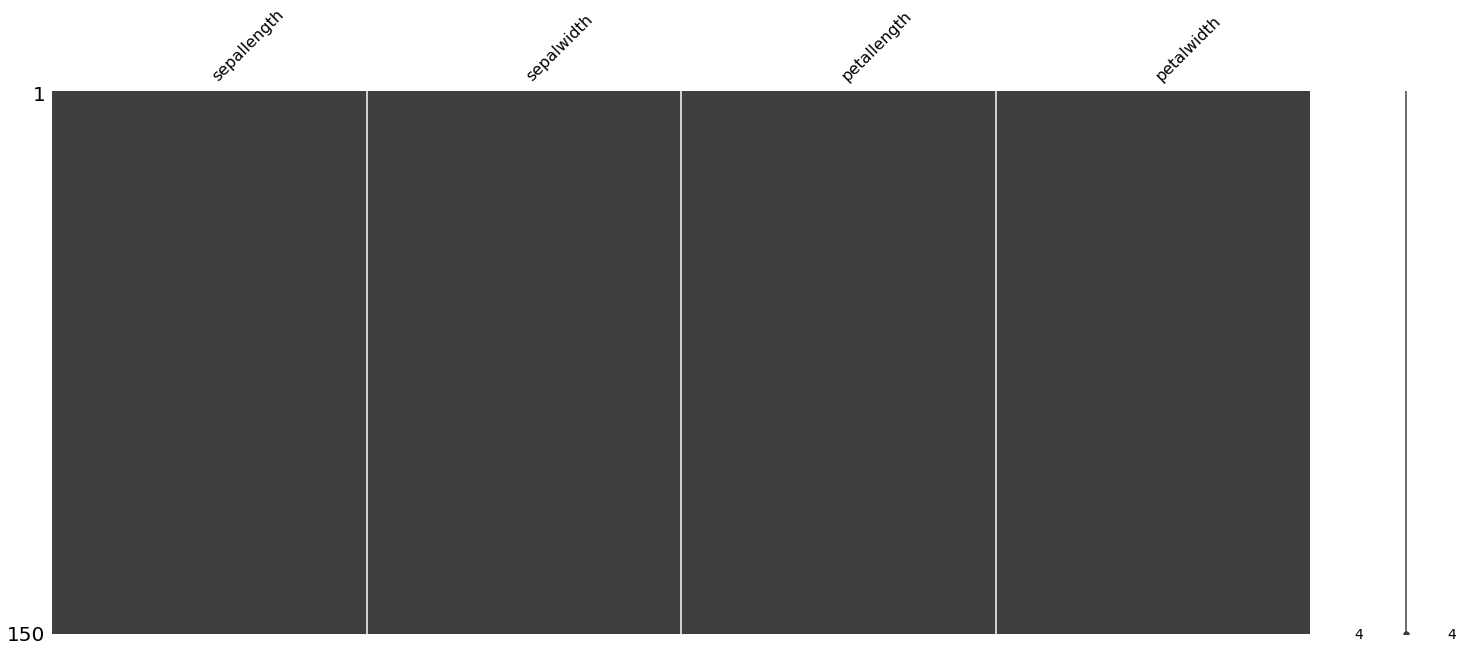

In [17]:
msno.matrix(df)
plt.show() 